# Final Project: Comparative Analysis of Machine Learning Models to Classify Obesity Level

## Project Plan

### Objective

The objective of this project is to evaluate the accuracy of different modeling approaches in the context of classifying obesity level. The analysis will compare the performance of several methods, including multinomial logistic regression, boosted multinomial logistic regression, and random forests. Additionally, hyperparameter optimization will be used to try to enhance the models' predictive accuracy.

### Hypotheses

I expect that the multinomial logistic regression, when combined with boosted techniques and optimized hyperparameters, will outperform standard multinomial logistic regression and random forests in accurately classifying obesity levels in the dataset.

### The Data

For this project, I will be using dataset, [Estimation of Obesity Levels Based On Eating Habits and Physical Condition](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition), from the Machine Learning Repository. Data was collected from Mexico, Peru, and Columbia. 77% of the data was synthetically generated and 23% was directly collected.

**Description of Data**

Eating Habits Features:

- `FACV` (Do you eat high caloric food frequently?)
- `FCVC` (Do you usually eat vegetables in your meals?)
- `NCP` (How many main meals do you have daily?)
- `CAEC` (Do you eat any food between meals?)
- `CH20` (How much water do you drink daily?)
- `SCC` (Do you monitor the calories you eat daily?)
- `CALC` (How often do you drink alcohol?)


Physical Condition Features:

- `SMOKE` (Do you smoke?)
- `FAF` (How often do you have physical activity?)
- `TUE` (How much time do you use technological devices such as cell phone, videogames, television, computer, and others?)
- `MTRANS` (Which transportation do you usually use?)
 

Other Features:

- `family_history_with_overweight` (Has a family member suffered or suffers from overweight?) 
- `Gender` (Female or Male)
- `Age` (years)
- `Height` (meters)
- `Weight` (kilograms)

Target Variable:

- `NObeyesdad` (Obesity level)
>`Insufficient_Weight`,`Normal_weight`,`Overweight_Level_I`,`Overweight_Level_II`,`Obesity_Type_I`,`Obesity_Type_II`,`Obesity_Type_III`

## Data Preparation & Initial Analysis

#### Import Statements

Below are all the import statements necessary to do the coding for this analysis.

In [277]:
# pip install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from ISLP.models import ModelSpec as MS
from statsmodels.api import OLS
from functools import partial
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [278]:
# to ignore warnings cluttering my notebook
import warnings
warnings.filterwarnings("ignore")

#### Loading in the Data Set

In [280]:
obesity = pd.read_csv('ObesityData.csv')

First, I look at the first few rows of the raw dataset before doing any cleaning. Right away, I notice that there are categorical and continuous variables. Since there are categorical variables, I will need to make dummy variables during the preparation process. Since there are continuous variables on different scales such as weight, age, height, and others, I will need to standardize the variables to put them all the same scale.

In [282]:
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


#### Column Names

Below are all the columns names in this dataset.

In [285]:
obesity.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

#### Renaming Response Variable

I am going to rename the response variable from `NObeyesdad` to `ObesityLevel` because "ObesityLevel" is a more intuitive name. It will make coding easier (for me).

In [288]:
obesity.rename(columns={'NObeyesdad': 'ObesityLevel'}, inplace=True)

#### Descriptive Statistics of Quantitative Features

Next, I look at the descriptive statistics of all the continuous variables. I see that the dataset contains people from ages 14 to 61. Based on the range of weight and height, it looks like they're measured in the metric system - kilograms and meters. FVCV (vegetables in meals) ranges from 1 to 3. This indicates how many meals people eat with vegetables. It seems that everyone has at least one meal with vegetables in it. It looks like people have 1 to 4 meals per day in this dataset. People drink between 1 and 3 liters of water each day. People spend 0 to 2 hours on technology each day. 

In [291]:
obesity.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2111.0,24.312600,6.345968,14.00,19.947192,22.777890,26.000000,61.00
Height,2111.0,1.701677,0.093305,1.45,1.630000,1.700499,1.768464,1.98
Weight,2111.0,86.586058,26.191172,39.00,65.473343,83.000000,107.430682,173.00
FCVC,2111.0,2.419043,0.533927,1.00,2.000000,2.385502,3.000000,3.00
NCP,2111.0,2.685628,0.778039,1.00,2.658738,3.000000,3.000000,4.00
CH2O,2111.0,2.008011,0.612953,1.00,1.584812,2.000000,2.477420,3.00
FAF,2111.0,1.010298,0.850592,0.00,0.124505,1.000000,1.666678,3.00
TUE,2111.0,0.657866,0.608927,0.00,0.000000,0.625350,1.000000,2.00


#### Handing Missing Values

Below I check the dataset for any null values and I found that there are none in this dataset.

In [293]:
obesity.isnull().any()

Gender                            False
Age                               False
Height                            False
Weight                            False
family_history_with_overweight    False
FAVC                              False
FCVC                              False
NCP                               False
CAEC                              False
SMOKE                             False
CH2O                              False
SCC                               False
FAF                               False
TUE                               False
CALC                              False
MTRANS                            False
ObesityLevel                      False
dtype: bool

#### Number of unique values in each column

Below I look at how many unique values there are in each column. I see that there are 7 in the response variable - indicating that there are observations in each of the 7 classes.

In [296]:
obesity.nunique()

Gender                               2
Age                               1402
Height                            1574
Weight                            1525
family_history_with_overweight       2
FAVC                                 2
FCVC                               810
NCP                                635
CAEC                                 4
SMOKE                                2
CH2O                              1268
SCC                                  2
FAF                               1190
TUE                               1129
CALC                                 4
MTRANS                               5
ObesityLevel                         7
dtype: int64

#### Classes in Response Variable

These are the class names in the response variable. Currently they are categorical so I will have to convert them to numeric labels.

In [299]:
obesity['ObesityLevel'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In descending order by BMI (Body Mass Index), it goes obesity type 3, obesity type 2, obesity type 1, overweight level 2, overweight level 1, normal weight, then insufficient weight.

#### Preprocessing Data

First, I give the response variable `ObesityLevel` numeric labels. I map in such a way that the lower the numeric label, the lower the BMI.

In [303]:
mapping = {
    'Insufficient_Weight': 0, 
    'Normal_Weight': 1, 
    'Overweight_Level_I': 2, 
    'Overweight_Level_II': 3, 
    'Obesity_Type_I': 4, 
    'Obesity_Type_II': 5, 
    'Obesity_Type_III': 6
}

obesity['ObesityLevel'] = obesity['ObesityLevel'].map(mapping)

#### Data Prep for Analysis

Below, I make the feature data frame, `X`, which contains all the features and the response variable, `y`, which contains `ObesityLevel`. Then, I convert all the categorical variables into dummy variables. 

In [306]:
X = obesity.drop('ObesityLevel', axis=1)
y = obesity['ObesityLevel']
X = pd.get_dummies(X, drop_first=True)

#### Exploring Patterns in Data

First, I look at the distribution of observations by Obesity Level.

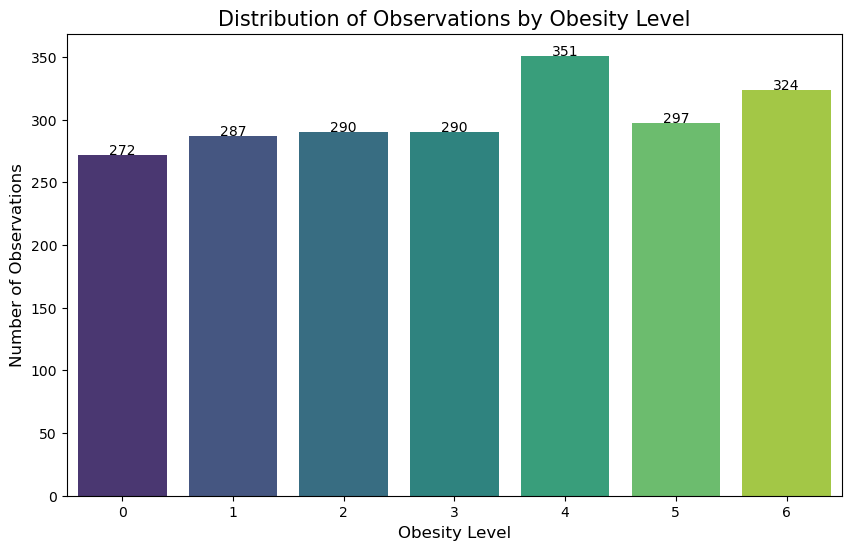

In [309]:
counts = obesity['ObesityLevel'].value_counts()
counts = counts.sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette="viridis")

plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)
plt.title('Distribution of Observations by Obesity Level', fontsize=15)
for i, count in enumerate(counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=10)
plt.show()

It appears that the observations are well distributed. Each class has at least 270 observations. This is a good distribution of observations since the class sizes are balanced.

Next, I look at the correlation matrix.

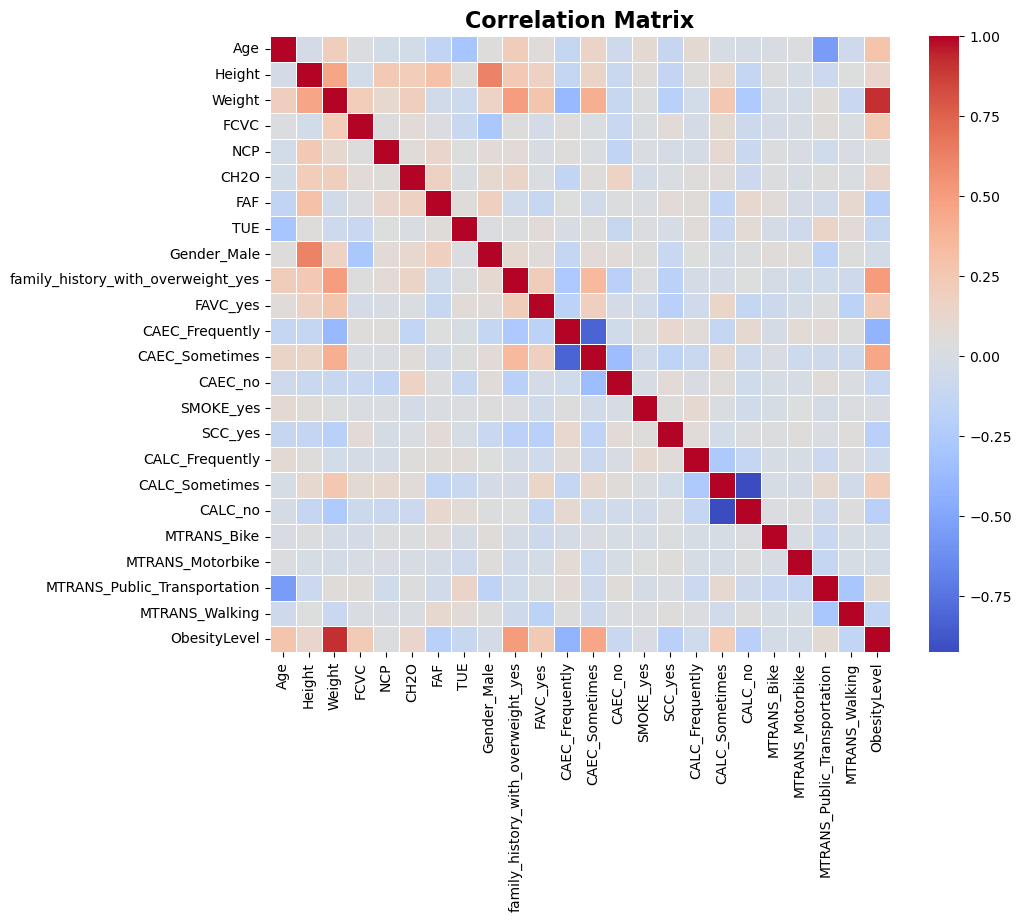

In [312]:
full_data = pd.concat([X, y], axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(full_data.corr(numeric_only=True), cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

It is important to note that `Weight` and `ObesityLevel` are highly correlated as we would expect. Other features that have notable but not strong correlation with `ObesityLevel` are `family_with_history_overweight`, `CAEC_Sometimes` (sometimes has food between meals), and `CAEC_Frequently` (frequently has food between meals). Some features with little correlation are `Age`, `FAVC_yes` (frequently eats high-calorie foods), and `CALC_Sometimes` (alcohol consumption).

Next, I look at the boxplots of each feature against the response variable, `ObesityLevel`.

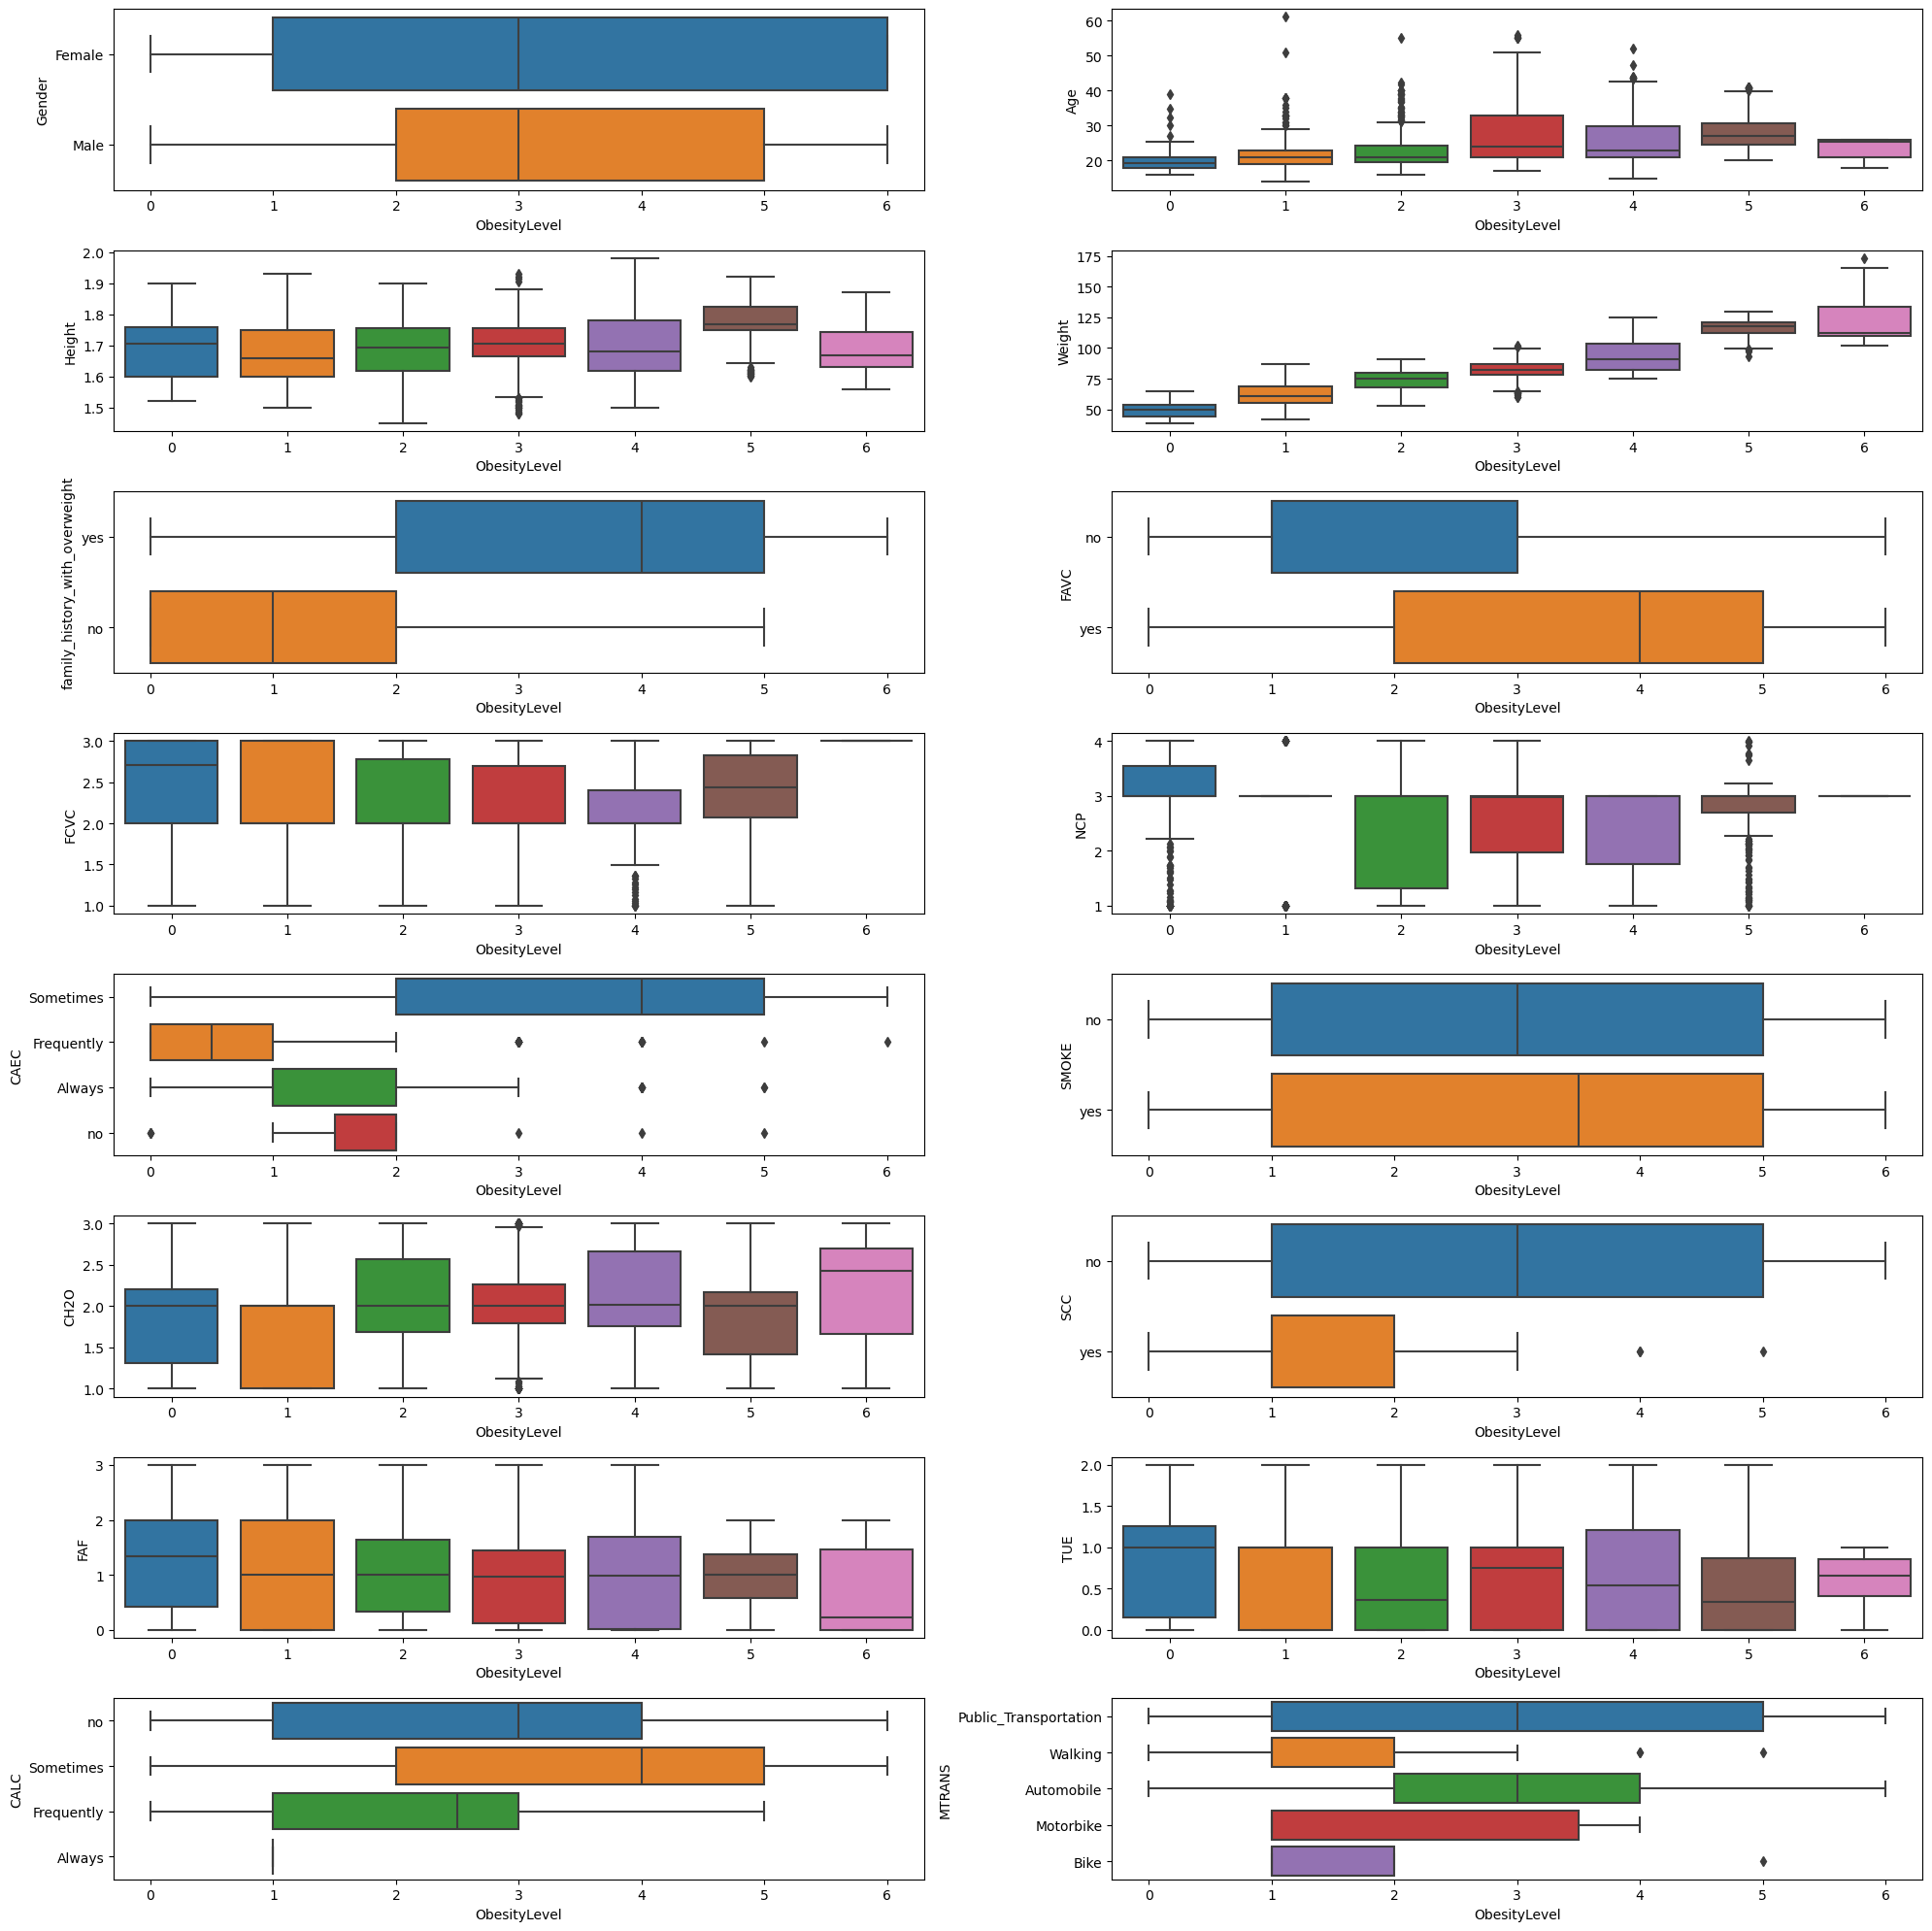

In [315]:
plt.figure(figsize=(20, 20))

X_variables = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 
               'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 
               'CALC', 'MTRANS']

for i, var in enumerate(X_variables, 1):
    plt.subplot(8, 2, i)
    sns.boxplot(x=obesity['ObesityLevel'], y=obesity[var])
    plt.xlabel('ObesityLevel')
    plt.ylabel(var)
    
plt.tight_layout()
plt.show()

Interpretation of Obesity Level vs...

1. Gender
- The median is the same for both genders, indicating that obesity levels do not differ significantly by gender.

2. Age
- Age seems to fluctuate slightly with different obesity levels. This indicates that age could have some influence on obesity level.

3. Height
- The median height for obesity level 5 (Obesity Type 2) noticably stands out. 

4. Weight
- There is a clear rising trend in weight as obesity level increases, which is expected.

5. Family History with Overweight
- Those with a family history of overweight have much more values in higher obesity levels, which suggests this is a predictor of obesity.

6. FAVC (Frequent Consumption of High-Calorie Food)
- Those who consume high-calorie foods frequently are concentrated in higher obesity levels, suggesting that this is a predictor of obesity.

7. FCVC (Frequency of Vegetable Consumption)
- It appears that every observation in Obesity Type 3 class eats vegetables in 3 meals. Other than that, FCVC seems steady across obesity levels.

8. NCP (Number of Meals per Day)
- Almost every observation for those in the normal weight and the obesity type 3 category eat 3 meals a day. This indicates that number of meals might not be a good predictor.

9. CAEC (Consumption of Food Between Meals)
- Those who frequently or always snack between meals have lower obesity levels.

10. SMOKE
- Those who smoke have a slightly higher median obesity level. Overall, those who smoke and don't smoke have similar obesity levels.

11. CH20 (Daily Water Consumption)
- Daily water consumption seems to fluctuate a decent amount across obesity levels. Consumption levels for obesity levels other than "normal weight" are higher.

12. SCC (Calorie Monitoring)
- Individuals who do not monitor their calories are concentrated more in higher obesity levels, indicating that calorie monitoring could help predict obesity.

13. FAF (Physical Activity)
- Lower levels of physical activity are concentrated in higher obesity levels.

14. TUE (Time Using Technology)
- Time using technology is relatively similar across all obesity levels.

15. CALC (Alcohol Consumption)
- Frequent alcohol consumption are concentrated in higher obesity levels, indicating that CALC could be a predictor for obesity.

16. MTRANS (Transportation)
- Active modes of transportation such walking and biking are concentrated is lower obesity levels, indicating that transportation could be an important predictor.


## Modeling Strategy & Implementation

Since the response variable in this dataset is a multi-class variable, I will need to use multi-class classification models. I will be exploring multinomial logistic regression, boosted logistic regression, and random forests.

#### Multinomial Logistic Regression

##### Using Validation set:

I split the data into a training set with 70% of the observations and a test set with the other 30% of observations. I standardized the features because there are continuous variables such as weight, height and age that are all on different scales.

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [321]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Set Accuracy: {accuracy}")

Validation Set Accuracy: 0.8564668769716088


Using a validation set approach, the multinomial logistic regression model has an accuracy of 0.8565. It is important to note that this accuracy is very dependent on what observations were randomly chosen for the training and test set. 

Below I show what features appear to be important from the above logistic regression model. From logistic regression, feature importance is really referring to the magnitude of scaled coefficients of variables. Those with the largest magnitude are interpreted as most important.

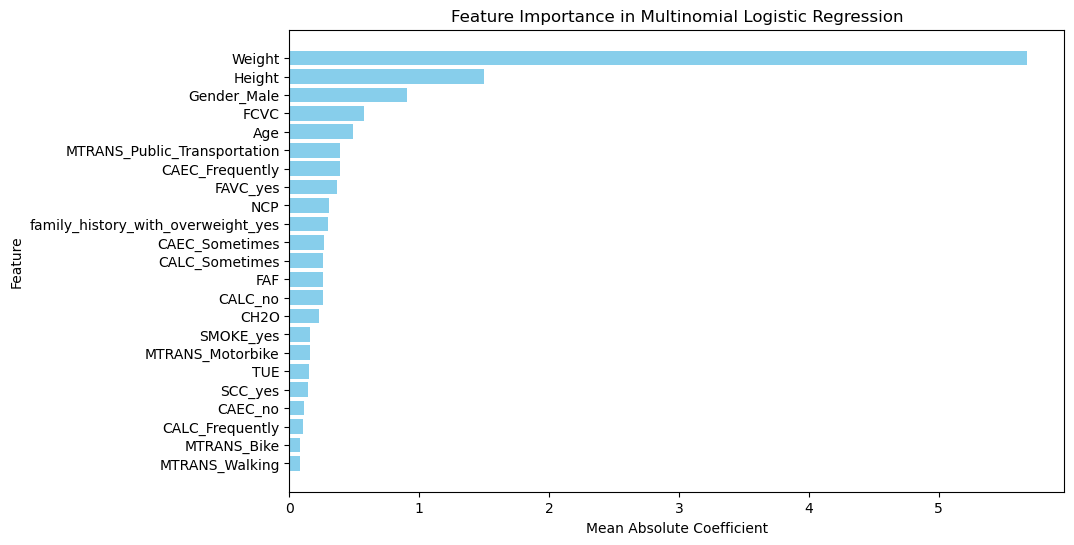

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

coefficients = model.coef_
features = X_train.columns

coef_df = pd.DataFrame(coefficients.T, index=features, columns=model.classes_)
coef_df['Mean_Abs_Coef'] = coef_df.abs().mean(axis=1)  # Mean absolute importance

# sort by importance
coef_df = coef_df.sort_values(by='Mean_Abs_Coef', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df.index, coef_df['Mean_Abs_Coef'], color='skyblue')
plt.xlabel('Mean Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance in Multinomial Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

Based off of this visualization, it appears that weight, height, gender are very important for classifying obesity level. This doesn't exactly match my interpretations from the correlation matrix and the boxplots made during the exploratory phase. Both exploratory visuals did show that weight appears to be correlated with obesity level as we would expect. However gender and height were not features that seemed to be highly correlated with obesity level in the correlation matrix. I did note that height fluctuated with obesity level in the boxplots though. It is interesting to note that `family_with_overweight_yes` does not high importance in this model. That is definitely something I would expect to have a larger coefficient based on the correlation matrix, the boxplot and my intuition.

##### Using 5-fold cross-validation:

Below, I use 5-fold cross-validation to find the accuracy of the multinomial logistic regression model.

In [328]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

Cross-Validation Accuracy Scores: [0.66903073 0.91469194 0.90047393 0.92180095 0.91232227]
Mean CV Accuracy: 0.8637


The cross-validation accuracy is slightly higher than the accuracy from the validation set approach. Cross-validation is a better estimation of accuracy since it takes the average of 5 different variations of test and training sets.

#### Boosted Multinomial Logistic Regression

Next, I run a boosted multinomial logistic regression model. For this boosted multinomial logistic regression problem I am using XGBoost. XGBoost makes decision trees and optimizes a loss function. So, while it does not technically use logistic regression models as weak learners, it still solves multiclass problems. In this context, boosting builds trees sequentially. Each new tree corrects the errors made by the previous ones. 

In [332]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(objective='multi:softprob', eval_metric='mlogloss'))
])

cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

Cross-Validation Accuracy Scores: [0.81560284 0.98815166 0.98341232 0.98341232 0.98341232]
Mean CV Accuracy: 0.9508


The accuracy from this model is really high, 0.9508. Next I am going to optimize one of the hyperparameters, max depth, to try to get even better accuracy. Max depth controls the maximum amount of splits each individual tree has. I want to note that I also explored optimizing a learning rate but it takes a lot of time to run. However, learning rate is a really important hyperparameter. It penalizes each tree and controls the impact that each individual tree has. The higher the learning rate, the less trees will be produced and thus each tree will have a larger impact. The lower the learning rate, the more trees and each tree will have a lower impact.

#### Hyperparameter Optimization for Boosted Multinomial Logistic Regression

Hyperparameter:

`max_depth` is the maximum depth of each individual tree.

In [336]:
param_grid = {'model__max_depth': list(range(1,10))}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best Max Depth:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Max Depth: {'model__max_depth': 7}
Best CV Accuracy: 0.9508027741364435


The optimal max depth found from 5-fold cross-validation is 7. After optimizing max depth, the model's accuracy is slightly better, 0.95, which I would expect to happen. 

#### Random Forests

Random forests is a method that reduces variance by averaging the predictions of multiple trees. The special aspect of random forests is that it decorrelates trees. Each tree is built on a random subset of features, which reduces the correlations between trees. 

First, I am going to run use the validation set approach to find the accuracy of random forest classification.

In [341]:
RF_model = RandomForestClassifier(random_state=1).fit(X_train, y_train)

y_hat_RF = RF_model.predict(X_test)

accuracy = accuracy_score(y_test, y_hat_RF)
print(f"Validation-set Accuracy: {accuracy:.4f}")

Validation-set Accuracy: 0.9306


The accuracy is extremely high for this model but like I said earlier, the validation set approach is highly dependent on what variables are in the training and test set. This accuracy is probably an overestimate.

Next, I use cross-validation to see the accuracy of the random forest.

In [344]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=1, class_weight='balanced')

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.70685579 0.98104265 0.98341232 0.98104265 0.98578199]
Mean CV Accuracy: 0.9276


The accuracy is lower than the validation set approach but it still very high. This accuracy is more trustworthy than the validation set approach anyways.

Note: `RandomForestClassifier()` selects `max_features` as the square root of the number of features by default.

Next, I look at feature importance in the random forest model. Feature importance in a random forest measures how much each feature contributes to the model. It provides a ranking of the features based on their influence on the model's accuracy. 

In [348]:
feature_names = X_train.columns

feature_imp = pd.DataFrame(
    {'Importance': RF_model.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='Importance', ascending=False)

,Importance
Weight,0.280856
Age,0.094531
Height,0.093207
FCVC,0.087797
Gender_Male,0.056445
NCP,0.055534
TUE,0.053479
FAF,0.052469
CH2O,0.049322
family_history_with_overweight_yes,0.028480


Similarly to my intuition, the correlation matrix, the boxplots, and the feature importance found from multinomial logistic regression, it appears that weight is an important feature for classifying obesity level. However, the next few important features differ from the other results. Again, I am surprised to see that `family_history_with_overweight_yes` does not have higher variable importance. Based on the correlation matrix, boxplots, and my own intuition, it seems like it would help classify obesity level but neither of the classification models show it as important.

#### Hyperparameter Optimization for Random Forests

For random forest hyperparameter optimization, I use max depth like I did for boosting. Max depth controls the maximum number of splits for each tree. 

In [352]:
param_grid = {'max_depth': list(range(1, 20))}

rf_model = RandomForestClassifier(random_state=1)


grid_search = GridSearchCV(rf_model,param_grid,scoring='accuracy',cv=5,n_jobs=-1)

grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'max_depth': 16}
Best CV Accuracy: 0.9309


With hyperparameter optimization, the accuracy improved slightly. However, I am a bit skeptical about how interpretable this model is. Given that it chose 16 as the best max depth, the tree has a lot of splits. This makes the tree a lot more complex and harder to interpret. It also is subject to some overfitting with it being this complex.

### Model Accuracy Comparison

Legend:

- `LRVS` = Multinomial Logistic Regression using Validation Set
- `LRCV` = Multinomial Logistic Regression using Cross-Validation
- `BLR` = Boosted Multinomial Logistic Regression
- `BLRHO` = Boosted Multinomial Logistic Regression with Hyperparameter Optimization
- `RFVS` = Random Forests using Validation Set
- `RFCV` = Random Forests using Cross-Validation
- `RFHO` = Random Forests with Hyperparameter Optimization

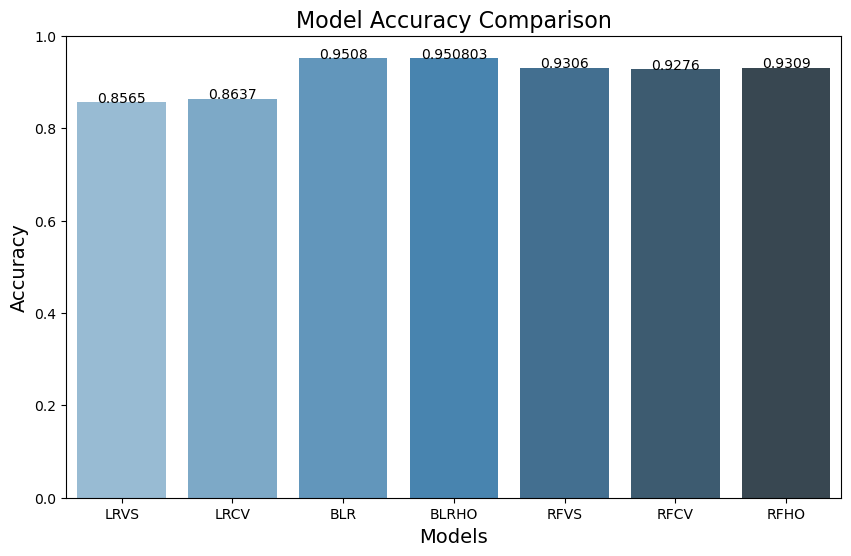

In [384]:
models = ['LRVS', 'LRCV', 'BLR', 'BLRHO', 'RFVS','RFCV', 'RFHO']
accuracies = [0.8565, 0.8637, 0.9508, 0.950803, 0.9306, 0.9276, .9309]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='Blues_d')

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy, str(accuracy), ha='center', fontsize=10)
plt.show()

### Model Comparison Results

**Multinomial Logistic Regression (`LRVS`, `LRCV`):**

The models `LRVS` (Multinomial Logistic Regression using Validation Set) and `LRCV` (Multinomial Logistic Regression using Cross-Validation) show accuracies of 0.8565 and 0.8637. These are relatively good results, with cross-validation slightly outperforming the validation set approach. However, these models are likely using simpler methodologies and might be outperformed by more complex models like the ones listed below. 

**Boosted Multinomial Logistic Regression (`BLR`, `BLRHO`):**

`BLR` (Boosted Multinomial Logistic Regression) using XGBoost achieves a high accuracy of 0.9508, while `BLRHO` (Boosted Multinomial Logistic Regression with Hyperparameter Optimization) achieves an accuracy of 0.950803. The performance is close, indicating that hyperparameter optimization did not significantly improve the model in this case, though it may have been better if I used different tuning parameters. I could've used learning rate but the computational cost was too high. It took a really long time to run the cross-validation for learning rate. However, I do believe that learning rate might have been a more valuable tuning parameter. It controls the impact that each tree has. Boosted models tend to perform well on complex datasets due to their ability to reduce variance, which is reflected in these results.

**Random Forests (`RFVS`, `RFCV`, `RFHO`):**

The `RFVS` model (Random Forests using Validation Set) has an accuracy of 0.9306, which is slightly lower than the boosted models but still close.
`RFCV` (Random Forests using Cross-Validation) has an accuracy of 0.9276, which is slightly lower than RFVS, indicating that cross-validation did not lead to a major improvement over the single validation set approach. If I changed the random state though, these results could be very different. The validation set approach is variable depending on which observation end up in the training and test set. It's really not an accurate estimate of model performace. Cross-validation accuracy is more reliable.
The `RFHO` model (Random Forests with Hyperparameter Optimization) shows an accuracy of 0.9309, which is higher than the cross-validated approach. This suggests that hyperparameter optimization did slighly enhance the performance, possibly due to the dataset's characteristics. 

Overall though, the random forest models and the boosted models were performing well anyways before hyperparameter optimization. That could be why we aren't seeing significant improvements in accuracy.

**Summary:**

Best Performing Models: The Boosted Multinomial Logistic Regression models (`BLR` and `BLRHO`) outperform the other models, suggesting that boosting is highly effective for this dataset. The accuracy difference between BLR and BLRHO is similar, indicating that hyperparameter tuning may not have had a substantial impact. This could be due to the choice of hyperparameter (max depth) or the fact that the boosted model before tuning was already performing really well.

Random Forests: The Random Forest models perform well but not as well as the boosted models. The accuracy improvement with hyperparameter tuning (`RFHO`) is small.

Logistic Regression Models: The Multinomial Logistic Regression models (`LRVS` and `LRCV`) perform well but are outperformed by the more complex models (Boosting and Random Forests), suggesting that while Logistic Regression works well for this problem but more complex models can lead to improvements in model accuracy.

**Conclusion:**
For this obesity dataset, Boosted Multinomial Logistic Regression seems to be the most effective model, with Random Forests close behind. Logistic Regression still performed well but it may not be the best choice for maximizing performance in this context.

## Presentation

- Here's a [link](./FinalProject.pdf) to my presentation.